In [2]:
# Process Data
from pyspark.sql import SparkSession # Spark Session
from pyspark.sql.functions import lit  # functions for 
from pyspark.sql.functions import col, sum

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType, StringType


## Using Spark with Hive

In [5]:
# Configuración antes de crear la sesión de Spark
spark = SparkSession.builder \
    .appName("StockTweetsToHive") \
    .enableHiveSupport() \
    .getOrCreate()

## Reading the data from Hive

In [6]:
spark.sql("Show databases;").show()

+---------+
|namespace|
+---------+
|benchmark|
|      ca2|
|  default|
| testhive|
+---------+



In [7]:
spark.sql("USE ca2;")

DataFrame[]

In [8]:
tweets = spark.sql("Select * from tweets;")

In [9]:
tweets.show()
print(tweets.count())

+------+----------+------+--------------------+
|    id|      date|ticker|               tweet|
+------+----------+------+--------------------+
|100001|01/01/2020|  AMZN|$AMZN Dow futures...|
|100002|01/01/2020|  TSLA|$TSLA Daddy's dri...|
|100003|01/01/2020|  AAPL|$AAPL We’ll been ...|
|100004|01/01/2020|  TSLA|$TSLA happy new y...|
|100005|01/01/2020|  TSLA|"$TSLA haha just ...|
|100006|01/01/2020|  TSLA|$TSLA NOBODY: Gas...|
|100007|02/01/2020|  AAPL|$AAPL $300 calls ...|
|100008|02/01/2020|  AAPL|$AAPL Remember, i...|
|100009|02/01/2020|  AAPL|$AAPL called it, ...|
|100010|02/01/2020|    HD|$HD Bought more a...|
|100011|02/01/2020|  AAPL|Apple is taking t...|
|100012|02/01/2020|  AAPL|$AAPL not a bad d...|
|100013|02/01/2020|  AAPL|$AAPL where are a...|
|100014|03/01/2020|  NVDA|$NVDA This should...|
|100015|03/01/2020|  AAPL|$AAPL tomorrow bu...|
|100016|03/01/2020|  AAPL|$AAPL Thanks for ...|
|100017|03/01/2020|  AAPL|$AAPL leave enoug...|
|100018|03/01/2020|  AAPL|$AAPL short th

# EDA from tweets

## 1.- Initial display and basic description

In [10]:
# Filtrar el dataframe para las 5 compañías
tickers = ["BAC", "DIS", "PG", "TSLA", "WMT"]
tweets = tweets.filter(tweets['ticker'].isin(tickers))

In [11]:
# Show the firsts rows 
tweets.select('tweet').show(10)

# get statistic descriptive 
tweets.select('tweet').describe().show()

+--------------------+
|               tweet|
+--------------------+
|$TSLA Daddy's dri...|
|$TSLA happy new y...|
|"$TSLA haha just ...|
|$TSLA NOBODY: Gas...|
|$TSLA  I must ris...|
|$TSLA shorts are ...|
|$TSLA Don’t short...|
|$TSLA 🐻 not see ...|
|$TSLA  can one he...|
|$TSLA Ignore the ...|
+--------------------+
only showing top 10 rows

+-------+--------------------+
|summary|               tweet|
+-------+--------------------+
|  count|                4959|
|   mean|                null|
| stddev|                null|
|    min| Bummer that $TSL...|
|    max|🚨🔥☆☆☆ $TSLA ☆☆☆...|
+-------+--------------------+



## 2.- Review of null or empty values

In [12]:
# Contar valores nulos o vacíos en la columna 'tweet'
tweets.filter(tweets['tweet'].isNull()).count()
tweets.filter(tweets['tweet'] == '').count()


0

## 3.- Length of tweets

In [13]:
from pyspark.sql.functions import length

# Calcular la longitud de los tweets
df_with_length_filtered = tweets.withColumn("tweet_length", length(tweets['tweet']))

# Estadísticas sobre la longitud de los tweets
df_with_length_filtered.select('tweet_length').describe().show()

# Mostrar tweets con longitud extrema
df_with_length_filtered.filter(df_with_length_filtered['tweet_length'] > 200).show(10)  # Ejemplo para tweets con más de 200 caracteres


+-------+-----------------+
|summary|     tweet_length|
+-------+-----------------+
|  count|             4959|
|   mean|81.52046783625731|
| stddev|46.21096124505679|
|    min|               23|
|    max|              255|
+-------+-----------------+

+------+----------+------+--------------------+------------+
|    id|      date|ticker|               tweet|tweet_length|
+------+----------+------+--------------------+------------+
|100047|07/01/2020|  TSLA|$TSLA bears 🐻 I ...|         235|
|100064|08/01/2020|   DIS|$DIS small piece ...|         237|
|100250|22/01/2020|  TSLA|$TSLA y’all need ...|         223|
|100279|23/01/2020|  TSLA|$TSLA If someone ...|         224|
|100308|24/01/2020|  TSLA|$TSLA lol its so ...|         237|
|100322|28/01/2020|  TSLA|$TSLA there'san e...|         234|
|100473|03/02/2020|  TSLA|$TSLA Unbelievabl...|         222|
|100594|06/02/2020|  TSLA|$TSLA i am going ...|         244|
|100733|13/02/2020|  TSLA|$TSLA i freaking ...|         215|
|100874|24/02/20

## 4.- Word frequency

In [14]:
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import col

# Tokenizar los tweets (dividir en palabras)
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
df_tokenized_filtered = tokenizer.transform(tweets)

# Contar la frecuencia de palabras
from pyspark.sql.functions import explode

word_count_filtered = df_tokenized_filtered.withColumn("word", explode(df_tokenized_filtered['words'])) \
                                           .groupBy("word").count() \
                                           .orderBy(col('count').desc())

# Mostrar las 10 palabras más frecuentes para las 5 compañías
word_count_filtered.show(10)


+-----+-----+
| word|count|
+-----+-----+
|$tsla| 4285|
|  the| 2052|
|   to| 1809|
|     | 1469|
|    a| 1210|
| this| 1091|
|    i|  984|
|   is|  983|
|  and|  975|
|   in|  724|
+-----+-----+
only showing top 10 rows



## 5.- Word cloud 

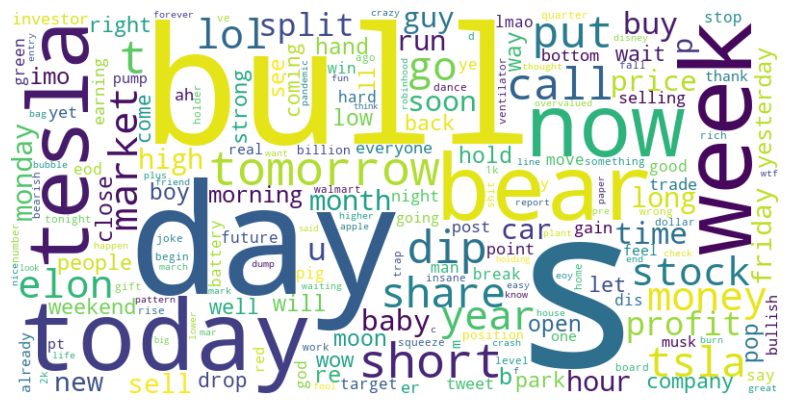

In [15]:
from wordcloud import WordCloud

# Obtener las palabras más frecuentes para las 5 compañías
words_filtered = word_count_filtered.toPandas()
words_str_filtered = ' '.join(words_filtered['word'])

# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(words_str_filtered)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


## 6.- Text cleaning

In [16]:
import re
import emoji
import string

# Función para limpiar texto
def clean_text(tweet):
    # Eliminar emojis
    tweet = emoji.replace_emoji(tweet, replace='')  # Elimina los emojis

    # Eliminar menciones de usuarios (palabras que empiezan con '@')
    tweet = re.sub(r'@\w+', '', tweet)

    # Eliminar URLs
    tweet = re.sub(r'http\S+|www\S+', '', tweet)

    # Eliminar hashtags (si no quieres conservar los hashtags)
    tweet = re.sub(r'#\w+', '', tweet)

    # Eliminar puntuación
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # Eliminar números (si no son relevantes para el análisis)
    tweet = re.sub(r'\d+', '', tweet)

    # Convertir a minúsculas
    tweet = tweet.lower()

    # Eliminar espacios extra
    tweet = re.sub(r'\s+', ' ', tweet).strip()

    return tweet

# Convertir la función en un UDF para PySpark
clean_text_udf = udf(clean_text, StringType())

In [17]:
from pyspark.sql.functions import regexp_replace

# Eliminar menciones (@usuario) y enlaces (http://...)
df_cleaned = tweets.withColumn("cleaned_tweet", clean_text_udf(tweets['tweet']))

# Mostrar tweets limpiados
df_cleaned.select('tweet','cleaned_tweet').show(20)


+--------------------+--------------------+
|               tweet|       cleaned_tweet|
+--------------------+--------------------+
|$TSLA Daddy's dri...|tsla daddys drink...|
|$TSLA happy new y...|tsla happy new ye...|
|"$TSLA haha just ...|tsla haha just a ...|
|$TSLA NOBODY: Gas...|tsla nobody gas c...|
|$TSLA  I must ris...|tsla i must rise ...|
|$TSLA shorts are ...|tsla shorts are f...|
|$TSLA Don’t short...|tsla don’t short ...|
|$TSLA 🐻 not see ...|tsla not see anyt...|
|$TSLA  can one he...|tsla can one hear...|
|$TSLA Ignore the ...|tsla ignore the c...|
|$TSLA  Squeal lik...|tsla squeal like ...|
|$TSLA shorts thou...|tsla shorts thoug...|
|$TSLA if you had ...|tsla if you had o...|
|Once again $TSLA ...|once again tsla k...|
|$TSLA BUT BUTT WW...|tsla but butt ww ...|
|$TSLA Congratulat...|tsla congratulati...|
|$TSLA these bears...|tsla these bears ...|
|$TSLA Top of the ...|tsla top of the c...|
|$TSLA wow jpm wit...|tsla wow jpm with...|
|$DIS Just keep fa...|dis just ke

# Sentiment analysis for Tweets

### Implementation Textblob

In [18]:
from textblob import TextBlob

# Función para analizar el sentimiento usando TextBlob
def analyze_sentiment(text):
    try:
        blob = TextBlob(text)
        # Polarity: -1 (negativo) a 1 (positivo)
        return blob.sentiment.polarity
    except Exception as e:
        return None

# Crear un UDF (User Defined Function) en PySpark para aplicar el análisis de sentimiento
sentiment_udf = udf(analyze_sentiment, FloatType())

# Aplicar el análisis de sentimiento sobre la columna 'tweet' para las 5 compañías
df_sentiment = df_cleaned.withColumn('sentiment', sentiment_udf(df_cleaned['tweet']))

# Mostrar las primeras filas con el sentimiento calculado
df_sentiment.select('tweet', 'sentiment').show(10)


+--------------------+----------+
|               tweet| sentiment|
+--------------------+----------+
|$TSLA Daddy's dri...|   0.15625|
|$TSLA happy new y...|0.46818182|
|"$TSLA haha just ...|       0.5|
|$TSLA NOBODY: Gas...|      -0.2|
|$TSLA  I must ris...|       0.5|
|$TSLA shorts are ...|       0.0|
|$TSLA Don’t short...|       0.4|
|$TSLA 🐻 not see ...|      0.05|
|$TSLA  can one he...|       0.0|
|$TSLA Ignore the ...|       1.0|
+--------------------+----------+
only showing top 10 rows



### Implementation Vander

In [19]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType


In [20]:
# Inicializamos el analizador de VADER
analyzer = SentimentIntensityAnalyzer()

In [21]:
# Función para calcular el sentimiento usando VADER
def get_sentiment(tweet):
    sentiment_score = analyzer.polarity_scores(tweet)
    return sentiment_score['compound']  # La clave 'compound' es la polaridad global
# Convertir la función en un UDF de PySpark
sentiment_udf = udf(get_sentiment, FloatType())

In [22]:
# Aplicar el análisis de sentimiento a la columna 'tweet'
df_sentiment = tweets.withColumn("sentiment", sentiment_udf(tweets['tweet']))

# Mostrar los primeros resultados con el sentimiento calculado
df_sentiment.select('tweet', 'sentiment').show(10)


+--------------------+---------+
|               tweet|sentiment|
+--------------------+---------+
|$TSLA Daddy's dri...|      0.0|
|$TSLA happy new y...|   0.7506|
|"$TSLA haha just ...|   0.9371|
|$TSLA NOBODY: Gas...|  -0.9588|
|$TSLA  I must ris...|   0.9876|
|$TSLA shorts are ...|  -0.4939|
|$TSLA Don’t short...|   0.5267|
|$TSLA 🐻 not see ...|  -0.2755|
|$TSLA  can one he...|   0.7184|
|$TSLA Ignore the ...|   0.7256|
+--------------------+---------+
only showing top 10 rows



I choosen Vader, because is more for informal text

### Categorizate 

In [23]:
# Función para categorizar el sentimiento
def sentiment_category(polarity):
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"

# Crear un UDF para aplicar la categorización
sentiment_category_udf = udf(sentiment_category, StringType())

# Añadir la columna con la categoría del sentimiento
df_sentiment_with_category = df_sentiment.withColumn('sentiment_category', sentiment_category_udf(df_sentiment['sentiment']))

# Mostrar las primeras filas con la categoría de sentimiento
df_sentiment_with_category.select('tweet', 'sentiment', 'sentiment_category').show(10)


+--------------------+---------+------------------+
|               tweet|sentiment|sentiment_category|
+--------------------+---------+------------------+
|$TSLA Daddy's dri...|      0.0|           neutral|
|$TSLA happy new y...|   0.7506|          positive|
|"$TSLA haha just ...|   0.9371|          positive|
|$TSLA NOBODY: Gas...|  -0.9588|          negative|
|$TSLA  I must ris...|   0.9876|          positive|
|$TSLA shorts are ...|  -0.4939|          negative|
|$TSLA Don’t short...|   0.5267|          positive|
|$TSLA 🐻 not see ...|  -0.2755|          negative|
|$TSLA  can one he...|   0.7184|          positive|
|$TSLA Ignore the ...|   0.7256|          positive|
+--------------------+---------+------------------+
only showing top 10 rows



### Length distribution of tweets (Visualization)

In [24]:
# Agrupar por 'ticker' y calcular el promedio de 'sentiment' y la cantidad de cada categoría de sentimiento
sentiment_stats = df_sentiment_with_category.groupBy('ticker', 'sentiment_category') \
    .count() \
    .orderBy('ticker', 'sentiment_category')

# Mostrar estadísticas de sentimiento por ticker
sentiment_stats.show()


+------+------------------+-----+
|ticker|sentiment_category|count|
+------+------------------+-----+
|   BAC|          negative|   15|
|   BAC|           neutral|   19|
|   BAC|          positive|   31|
|   DIS|          negative|  103|
|   DIS|           neutral|   89|
|   DIS|          positive|  240|
|    PG|          negative|    2|
|    PG|          positive|    1|
|  TSLA|          negative|  817|
|  TSLA|           neutral|  856|
|  TSLA|          positive| 2668|
|   WMT|          negative|   27|
|   WMT|           neutral|   27|
|   WMT|          positive|   64|
+------+------------------+-----+



In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

def show_distribution_tweets(data, title): 
    # Convertir el dataframe de Spark a pandas para graficar
    #pandas_df_sentiment = df_sentiment_with_category.toPandas()
    pandas_df_sentiment = data
    
    # Graficar la distribución de los sentimientos por ticker
    plt.figure(figsize=(10, 6))
    sns.countplot(x='ticker', hue='sentiment_category', data=pandas_df_sentiment)
    plt.title(title)
    plt.xlabel("Companies")
    plt.ylabel("Number of Tweets")
    plt.show()

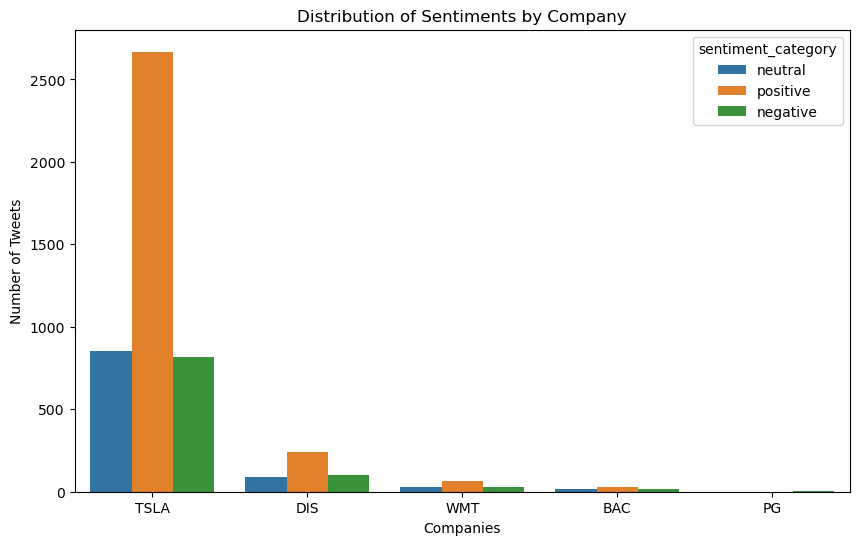

In [26]:
show_distribution_tweets(df_sentiment_with_category.toPandas(), "Distribution of Sentiments by Company")

# Processing Tweets

In [27]:
df_sentiment_with_category.select('*').show(10)

+------+----------+------+--------------------+---------+------------------+
|    id|      date|ticker|               tweet|sentiment|sentiment_category|
+------+----------+------+--------------------+---------+------------------+
|100002|01/01/2020|  TSLA|$TSLA Daddy's dri...|      0.0|           neutral|
|100004|01/01/2020|  TSLA|$TSLA happy new y...|   0.7506|          positive|
|100005|01/01/2020|  TSLA|"$TSLA haha just ...|   0.9371|          positive|
|100006|01/01/2020|  TSLA|$TSLA NOBODY: Gas...|  -0.9588|          negative|
|100019|03/01/2020|  TSLA|$TSLA  I must ris...|   0.9876|          positive|
|100020|03/01/2020|  TSLA|$TSLA shorts are ...|  -0.4939|          negative|
|100021|03/01/2020|  TSLA|$TSLA Don’t short...|   0.5267|          positive|
|100023|03/01/2020|  TSLA|$TSLA 🐻 not see ...|  -0.2755|          negative|
|100024|03/01/2020|  TSLA|$TSLA  can one he...|   0.7184|          positive|
|100025|03/01/2020|  TSLA|$TSLA Ignore the ...|   0.7256|          positive|


Selecting only imortant columns


In [28]:
df_setiment_final = df_sentiment_with_category.select('date', 'ticker', 'sentiment','sentiment_category')
df_setiment_final.show(5)
print(df_sentiment.count())

+----------+------+---------+------------------+
|      date|ticker|sentiment|sentiment_category|
+----------+------+---------+------------------+
|01/01/2020|  TSLA|      0.0|           neutral|
|01/01/2020|  TSLA|   0.7506|          positive|
|01/01/2020|  TSLA|   0.9371|          positive|
|01/01/2020|  TSLA|  -0.9588|          negative|
|03/01/2020|  TSLA|   0.9876|          positive|
+----------+------+---------+------------------+
only showing top 5 rows

4959


Grouping register with the same date and company

In [29]:
from pyspark.sql import functions as F

# Agrupar por 'date' y 'ticker' y calcular el promedio del 'sentiment'
df_sentiment_avg = df_setiment_final.groupBy('date', 'ticker') \
    .agg(
        F.avg('sentiment').alias('sentiment')
    )

df_sentiment_avg.show(5)


+----------+------+------------------+
|      date|ticker|         sentiment|
+----------+------+------------------+
|24/01/2020|  TSLA|0.2638999968767166|
|03/02/2020|  TSLA|0.4597533330321312|
|31/03/2020|   WMT|             0.875|
|01/07/2020|  TSLA| 0.248860003054142|
|03/11/2020|   WMT| 0.769599974155426|
+----------+------+------------------+
only showing top 5 rows



In [30]:
# Clasificar el sentimiento según el valor del promedio
df_sentiment_final = df_sentiment_avg.withColumn(
    'sentiment_category',
    F.when(df_sentiment_avg['sentiment'] > 0, 'Positive')
    .when(df_sentiment_avg['sentiment'] < 0, 'Negative')
    .otherwise('Neutral')
)

# Mostrar el resultado
df_sentiment_final.show(5)
print(df_sentiment_final.count())

+----------+------+------------------+------------------+
|      date|ticker|         sentiment|sentiment_category|
+----------+------+------------------+------------------+
|24/01/2020|  TSLA|0.2638999968767166|          Positive|
|03/02/2020|  TSLA|0.4597533330321312|          Positive|
|31/03/2020|   WMT|             0.875|          Positive|
|01/07/2020|  TSLA| 0.248860003054142|          Positive|
|03/11/2020|   WMT| 0.769599974155426|          Positive|
+----------+------+------------------+------------------+
only showing top 5 rows

534


Distribucion por fecha y empresa

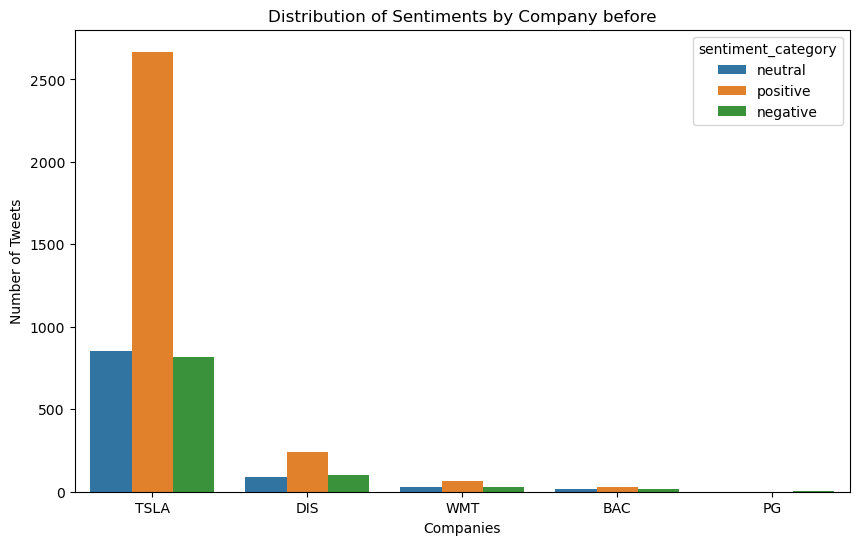

In [31]:
show_distribution_tweets(df_sentiment_with_category.toPandas(), "Distribution of Sentiments by Company before")

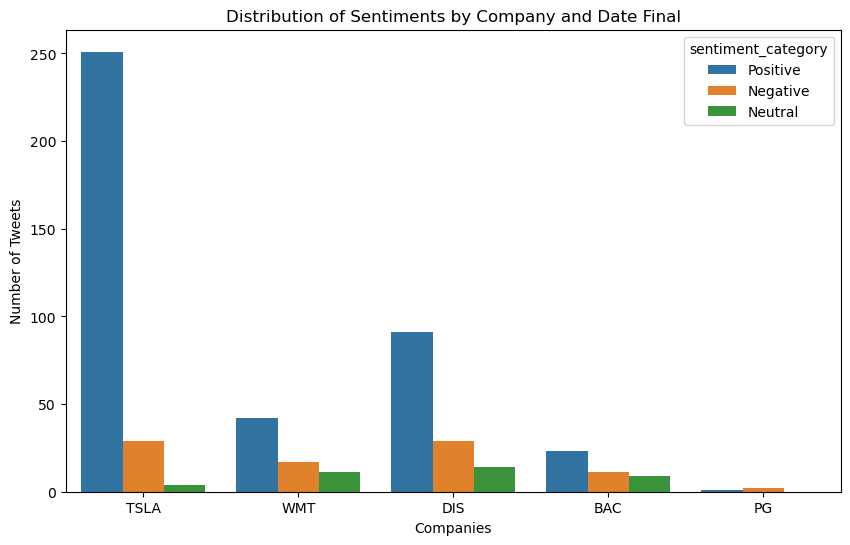

In [32]:
show_distribution_tweets(df_sentiment_final.toPandas(), "Distribution of Sentiments by Company and Date Final")

# Processing Prices

In [33]:
prices = spark.sql("Select * from prices;")
prices.show(5)
print(prices.count())

+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|      Date|              Open|              High|               Low|             Close|         Adj Close|   Volume|company|
+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|2019-12-31|              27.0|28.086000442504883| 26.80533218383789|  27.8886661529541|  27.8886661529541|154285500|   TSLA|
|2020-01-02|28.299999237060547|28.713333129882812| 28.11400032043457| 28.68400001525879| 28.68400001525879|142981500|   TSLA|
|2020-01-03|29.366666793823242|30.266666412353516|29.128000259399414|29.534000396728516|29.534000396728516|266677500|   TSLA|
|2020-01-06|29.364667892456055|30.104000091552734|29.333332061767578|  30.1026668548584|  30.1026668548584|151995000|   TSLA|
|2020-01-07|30.760000228881836|31.441999435424805|30.224000930786133|31.270666122436523|31.270666122436523|268231500| 

In [34]:
# Drop columns 
prices = prices[['Date', 'Close', 'Volume', 'company']]  # Mantén solo las columnas que necesitas
prices.show(5)
print(prices.count())

+----------+------------------+---------+-------+
|      Date|             Close|   Volume|company|
+----------+------------------+---------+-------+
|2019-12-31|  27.8886661529541|154285500|   TSLA|
|2020-01-02| 28.68400001525879|142981500|   TSLA|
|2020-01-03|29.534000396728516|266677500|   TSLA|
|2020-01-06|  30.1026668548584|151995000|   TSLA|
|2020-01-07|31.270666122436523|268231500|   TSLA|
+----------+------------------+---------+-------+
only showing top 5 rows

1270


## Join Data

In [35]:
# Convertir la fecha en formato adecuado
from pyspark.sql.functions import to_date

tweets_df = df_sentiment_final.withColumn("date", to_date(df_sentiment_final["date"], "dd/MM/yyyy"))

prices_df = prices.withColumn("date", to_date(prices["Date"], "yyyy-MM-dd"))


In [36]:
tweets_df.show(3)
print(tweets_df.count())

prices_df.show(3)
print(prices_df.count())

+----------+------+------------------+------------------+
|      date|ticker|         sentiment|sentiment_category|
+----------+------+------------------+------------------+
|2020-01-24|  TSLA|0.2638999968767166|          Positive|
|2020-02-03|  TSLA|0.4597533330321312|          Positive|
|2020-03-31|   WMT|             0.875|          Positive|
+----------+------+------------------+------------------+
only showing top 3 rows

534
+----------+------------------+---------+-------+
|      date|             Close|   Volume|company|
+----------+------------------+---------+-------+
|2019-12-31|  27.8886661529541|154285500|   TSLA|
|2020-01-02| 28.68400001525879|142981500|   TSLA|
|2020-01-03|29.534000396728516|266677500|   TSLA|
+----------+------------------+---------+-------+
only showing top 3 rows

1270


In [37]:
# Unir los datos por fecha y ticker
merged_df = tweets_df.join(prices_df, (tweets_df["date"] == prices_df["date"]) & (tweets_df["ticker"] == prices_df["company"]), "right")
merged_df.show(5)
print(merged_df.count())

+----------+------+--------------------+------------------+----------+------------------+---------+-------+
|      date|ticker|           sentiment|sentiment_category|      date|             Close|   Volume|company|
+----------+------+--------------------+------------------+----------+------------------+---------+-------+
|      null|  null|                null|              null|2019-12-31|  27.8886661529541|154285500|   TSLA|
|2020-01-02|  TSLA|-0.32910001277923584|          Negative|2020-01-02| 28.68400001525879|142981500|   TSLA|
|2020-01-03|  TSLA| 0.36481667558352154|          Positive|2020-01-03|29.534000396728516|266677500|   TSLA|
|2020-01-06|  TSLA| 0.20195000618696213|          Positive|2020-01-06|  30.1026668548584|151995000|   TSLA|
|2020-01-07|  TSLA|  0.1834687520749867|          Positive|2020-01-07|31.270666122436523|268231500|   TSLA|
+----------+------+--------------------+------------------+----------+------------------+---------+-------+
only showing top 5 rows

127

In [38]:
# Eliminar columnas duplicadas, manteniendo solo las necesarias
merged_df = merged_df.drop(tweets_df["date"])
merged_df.show(5)
print(merged_df.count())

+------+--------------------+------------------+----------+------------------+---------+-------+
|ticker|           sentiment|sentiment_category|      date|             Close|   Volume|company|
+------+--------------------+------------------+----------+------------------+---------+-------+
|  null|                null|              null|2019-12-31|  27.8886661529541|154285500|   TSLA|
|  TSLA|-0.32910001277923584|          Negative|2020-01-02| 28.68400001525879|142981500|   TSLA|
|  TSLA| 0.36481667558352154|          Positive|2020-01-03|29.534000396728516|266677500|   TSLA|
|  TSLA| 0.20195000618696213|          Positive|2020-01-06|  30.1026668548584|151995000|   TSLA|
|  TSLA|  0.1834687520749867|          Positive|2020-01-07|31.270666122436523|268231500|   TSLA|
+------+--------------------+------------------+----------+------------------+---------+-------+
only showing top 5 rows

1270


In [39]:
# Eliminar columnas duplicadas, manteniendo solo las necesarias
merged_df = merged_df.drop(tweets_df["ticker"])
merged_df.show(5)
print(merged_df.count())

+--------------------+------------------+----------+------------------+---------+-------+
|           sentiment|sentiment_category|      date|             Close|   Volume|company|
+--------------------+------------------+----------+------------------+---------+-------+
|                null|              null|2019-12-31|  27.8886661529541|154285500|   TSLA|
|-0.32910001277923584|          Negative|2020-01-02| 28.68400001525879|142981500|   TSLA|
| 0.36481667558352154|          Positive|2020-01-03|29.534000396728516|266677500|   TSLA|
| 0.20195000618696213|          Positive|2020-01-06|  30.1026668548584|151995000|   TSLA|
|  0.1834687520749867|          Positive|2020-01-07|31.270666122436523|268231500|   TSLA|
+--------------------+------------------+----------+------------------+---------+-------+
only showing top 5 rows

1270


## Analysis and Preparation for Prediction

In [46]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F

# Filtrar los datos para las 5 compañías seleccionadas
companies = ['BAC', 'DIS', 'PG', 'TSLA', 'WMT']

# Crear un diccionario para almacenar los DataFrames filtrados por empresa
company_data = {}

# Iterar sobre las compañías
for company in companies:
    # Filtrar los datos para cada compañía
    company_data[company] = merged_df.filter(merged_df['company'] == company)
    
    # Contar cuántos valores nulos hay en la columna 'sentiment'
    null_sentiment_count = company_data[company].filter(F.col('sentiment').isNull()).count()
    total_count = company_data[company].count()
    
    # Calcular el porcentaje de valores nulos en la columna 'sentiment'
    null_percentage = null_sentiment_count / total_count
    print(f"Compañía: {company}, Porcentaje de valores nulos en 'sentiment': {null_percentage * 100:.2f}%")
    
    if null_percentage > 0.8:
        # Si más del 80% de los valores son nulos, rellenamos con 0 (Neutral)
        print(f"Más del 80% de valores nulos en 'sentiment' para {company}. Rellenando con 0.")
        company_data[company] = company_data[company].fillna({'sentiment': 0})
    else:
        # Si menos del 80% de los valores son nulos, usamos un modelo predictivo para rellenar los valores nulos
        
        # Primero, vamos a filtrar los datos para que solo queden las filas con valores no nulos en 'sentiment'
        train_data = company_data[company].filter(F.col('sentiment').isNotNull())
        
        # Usamos 'Close' y 'Volume' para predecir el 'sentiment'
        assembler = VectorAssembler(inputCols=['Close', 'Volume'], outputCol='features')
        train_data = assembler.transform(train_data)
        
        # Creamos y entrenamos un modelo de regresión (puede ser LinearRegression o RandomForestRegressor)
        lr = LinearRegression(featuresCol='features', labelCol='sentiment')
        lr_model = lr.fit(train_data)
        
        # Ahora usamos el modelo entrenado para predecir los valores nulos en 'sentiment'
        # Para ello, tomamos las filas con valores nulos en 'sentiment' y les asignamos las predicciones
        test_data = company_data[company].filter(F.col('sentiment').isNull())
        test_data = assembler.transform(test_data)
        
        # Realizamos las predicciones sobre los valores nulos
        predictions = lr_model.transform(test_data)
        
        # Reemplazamos los valores nulos con las predicciones
        company_data[company] = company_data[company].join(predictions.select('date', 'prediction'), on='date', how='left')
        
        # Actualizamos los valores nulos con las predicciones en 'sentiment'
        company_data[company] = company_data[company].withColumn(
            'sentiment', 
            F.coalesce(F.col('sentiment'), F.col('prediction'))
        )
        
        # Eliminamos la columna 'prediction' que ya no necesitamos
        company_data[company] = company_data[company].drop('prediction')
        
        print(f"Rellenando valores nulos con modelo predictivo para {company}.")
    
    # Mostrar los primeros registros después de rellenar los valores nulos
    company_data[company].show(5)

    # Contar nuevamente los valores nulos después de la imputación
    null_sentiment_count_after = company_data[company].filter(F.col('sentiment').isNull()).count()
    print(f"Cantidad de valores nulos en 'sentiment' después de rellenar para {company}: {null_sentiment_count_after}")


Compañía: BAC, Porcentaje de valores nulos en 'sentiment': 83.46%
Más del 80% de valores nulos en 'sentiment' para BAC. Rellenando con 0.
+---------+------------------+----------+------------------+--------+-------+
|sentiment|sentiment_category|      date|             Close|  Volume|company|
+---------+------------------+----------+------------------+--------+-------+
|      0.0|              null|2019-12-31|35.220001220703125|29630100|    BAC|
|      0.0|              null|2020-01-02| 35.63999938964844|37614200|    BAC|
|      0.0|              null|2020-01-03|34.900001525878906|50357900|    BAC|
|      0.0|              null|2020-01-06|34.849998474121094|42185000|    BAC|
|      0.0|              null|2020-01-07|34.619998931884766|34149000|    BAC|
+---------+------------------+----------+------------------+--------+-------+
only showing top 5 rows

Cantidad de valores nulos en 'sentiment' después de rellenar para BAC: 0
Compañía: DIS, Porcentaje de valores nulos en 'sentiment': 50.

24/12/07 04:03:20 WARN Instrumentation: [c6ebf255] regParam is zero, which might cause numerical instability and overfitting.


Rellenando valores nulos con modelo predictivo para DIS.
+----------+-------------------+------------------+------------------+-------+-------+
|      date|          sentiment|sentiment_category|             Close| Volume|company|
+----------+-------------------+------------------+------------------+-------+-------+
|2020-01-03|0.23630445582875098|              null|             146.5|7320200|    DIS|
|2020-01-07| -0.599399983882904|          Negative| 145.6999969482422|6906500|    DIS|
|2020-01-06|0.23481294849891363|              null|145.64999389648438|8262500|    DIS|
|2020-01-02|                0.0|           Neutral| 148.1999969482422|9502100|    DIS|
|2020-01-08|0.13804998993873596|          Positive|145.39999389648438|6984200|    DIS|
+----------+-------------------+------------------+------------------+-------+-------+
only showing top 5 rows

Cantidad de valores nulos en 'sentiment' después de rellenar para DIS: 0
Compañía: PG, Porcentaje de valores nulos en 'sentiment': 98.8

24/12/07 04:03:25 WARN Instrumentation: [a8191882] regParam is zero, which might cause numerical instability and overfitting.


Rellenando valores nulos con modelo predictivo para TSLA.
+----------+--------------------+------------------+------------------+---------+-------+
|      date|           sentiment|sentiment_category|             Close|   Volume|company|
+----------+--------------------+------------------+------------------+---------+-------+
|2020-01-03| 0.36481667558352154|          Positive|29.534000396728516|266677500|   TSLA|
|2020-01-07|  0.1834687520749867|          Positive|31.270666122436523|268231500|   TSLA|
|2020-01-06| 0.20195000618696213|          Positive|  30.1026668548584|151995000|   TSLA|
|2020-01-02|-0.32910001277923584|          Negative| 28.68400001525879|142981500|   TSLA|
|2020-01-08|  0.2836499963369634|          Positive| 32.80933380126953|467164500|   TSLA|
+----------+--------------------+------------------+------------------+---------+-------+
only showing top 5 rows

Cantidad de valores nulos en 'sentiment' después de rellenar para TSLA: 0
Compañía: WMT, Porcentaje de valo

24/12/07 04:03:28 WARN Instrumentation: [9fc0206e] regParam is zero, which might cause numerical instability and overfitting.


Rellenando valores nulos con modelo predictivo para WMT.
+----------+--------------------+------------------+------------------+-------+-------+
|      date|           sentiment|sentiment_category|             Close| Volume|company|
+----------+--------------------+------------------+------------------+-------+-------+
|2019-12-31| 0.20101945755136155|              null|118.83999633789062|4912000|    WMT|
|2020-01-02| 0.20791795688384196|              null|118.94000244140625|6764900|    WMT|
|2020-01-03|  0.2040209061545875|              null|117.88999938964844|5399200|    WMT|
|2020-01-06|  0.2082769930184513|              null| 117.6500015258789|6445500|    WMT|
|2020-01-07|-0.49390000104904175|          Negative|116.55999755859375|6846900|    WMT|
+----------+--------------------+------------------+------------------+-------+-------+
only showing top 5 rows

Cantidad de valores nulos en 'sentiment' después de rellenar para WMT: 0


### ARIMA Model

In [54]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_squared_error

# Preprocesar los datos para cada compañía
for company in companies:
    # Extraemos el DataFrame de la compañía desde el diccionario company_data
    data = company_data[company]
    
    # Asegurarse de que 'date' sea de tipo fecha y 'Close' sea numérico
    data = data.withColumn('date', F.to_date(data['date'], 'yyyy-MM-dd'))

    # Convertir los datos de Spark a Pandas para poder usar ARIMA
    data_pandas = data.select('date', 'Close').toPandas()
    
    # Establecemos 'date' como índice para que ARIMA lo pueda usar correctamente
    data_pandas.set_index('date', inplace=True)
    
    # Solo usamos la columna 'Close' para ARIMA
    close_prices = data_pandas['Close']
    
    # Asegúrate de que la serie sea estacionaria (diferenciamos si es necesario)
    close_prices_diff = close_prices.diff().dropna()

    # Definir y ajustar el modelo ARIMA
    model = ARIMA(close_prices_diff, order=(1, 1, 1))  # Ejemplo de p=1, d=1, q=1
    model_fit = model.fit()

    # Predicciones a 1, 3, 7 días hacia el futuro
    forecast_1_day = model_fit.forecast(steps=1)
    forecast_3_days = model_fit.forecast(steps=3)
    forecast_7_days = model_fit.forecast(steps=7)

    print(f"Predicción ARIMA para {company}: 1 día: {forecast_1_day}, 3 días: {forecast_3_days}, 7 días: {forecast_7_days}")
    
    # Evaluar el modelo usando RMSE o alguna otra métrica
    # Usamos los últimos 7 días para la evaluación (ajustamos según el rango temporal de tus datos)
    y_true = close_prices[-7:]  # Últimos 7 días como ejemplo para la evaluación
    y_pred = model_fit.forecast(steps=7)
    
    # Calcular RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"RMSE ARIMA para {company}: {rmse}")


/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  retur

Predicción ARIMA para BAC: 1 día: 253    0.008678
dtype: float64, 3 días: 253    0.008678
254    0.069074
255    0.057722
Name: predicted_mean, dtype: float64, 7 días: 253    0.008678
254    0.069074
255    0.057722
256    0.059856
257    0.059454
258    0.059530
259    0.059516
Name: predicted_mean, dtype: float64
RMSE ARIMA para BAC: 29.898146683136957


/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/l

Predicción ARIMA para DIS: 1 día: 253   -6.514935
dtype: float64, 3 días: 253   -6.514935
254    3.034077
255   -1.535402
Name: predicted_mean, dtype: float64, 7 días: 253   -6.514935
254    3.034077
255   -1.535402
256    0.651226
257   -0.395139
258    0.105577
259   -0.134030
Name: predicted_mean, dtype: float64
RMSE ARIMA para DIS: 118.5221277990063


/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  retur

Predicción ARIMA para PG: 1 día: 253   -0.200321
dtype: float64, 3 días: 253   -0.200321
254    0.106629
255    0.046629
Name: predicted_mean, dtype: float64, 7 días: 253   -0.200321
254    0.106629
255    0.046629
256    0.058357
257    0.056065
258    0.056513
259    0.056425
Name: predicted_mean, dtype: float64
RMSE ARIMA para PG: 137.78032251765597


/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/l

Predicción ARIMA para TSLA: 1 día: 253   -27.813617
dtype: float64, 3 días: 253   -27.813617
254    11.383067
255    -4.542434
Name: predicted_mean, dtype: float64, 7 días: 253   -27.813617
254    11.383067
255    -4.542434
256     1.928052
257    -0.700888
258     0.367243
259    -0.066736
Name: predicted_mean, dtype: float64
RMSE ARIMA para TSLA: 84.51666177673509
Predicción ARIMA para WMT: 1 día: 253   -10.179701
dtype: float64, 3 días: 253   -10.179701
254     4.377145
255    -1.800804
Name: predicted_mean, dtype: float64, 7 días: 253   -10.179701
254     4.377145
255    -1.800804
256     0.821127
257    -0.291624
258     0.180629
259    -0.019796
Name: predicted_mean, dtype: float64
RMSE ARIMA para WMT: 129.8316248088507


/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/l

### LSTM Model

In [55]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# Función para crear secuencias de datos (ventanas deslizantes) para el modelo LSTM
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Preprocesar los datos para cada compañía
for company in companies:
    # Extraemos el DataFrame de la compañía desde el diccionario company_data
    data = company_data[company]
    
    # Asegurarse de que 'date' sea de tipo fecha y 'Close' sea numérico
    data = data.withColumn('date', F.to_date(data['date'], 'yyyy-MM-dd'))

    # Convertir los datos de Spark a Pandas para poder usar LSTM
    data_pandas = data.select('date', 'Close').toPandas()
    
    # Establecemos 'date' como índice para trabajar con datos de series temporales
    data_pandas.set_index('date', inplace=True)
    
    # Solo usamos la columna 'Close' para LSTM
    close_prices = data_pandas['Close'].values.reshape(-1, 1)

    # Normalizar los precios de cierre
    scaler = MinMaxScaler(feature_range=(0, 1))
    close_prices_scaled = scaler.fit_transform(close_prices)
    
    # Dividir los datos en entrenamiento y prueba (70% entrenamiento, 30% prueba)
    train_size = int(len(close_prices_scaled) * 0.7)
    train_data = close_prices_scaled[:train_size]
    test_data = close_prices_scaled[train_size:]
    
    # Crear secuencias para el entrenamiento
    time_steps = 60  # Usaremos los últimos 60 días para predecir el siguiente día
    X_train, y_train = create_sequences(train_data, time_steps)
    X_test, y_test = create_sequences(test_data, time_steps)
    
    # Redimensionar las entradas para LSTM [muestras, pasos de tiempo, características]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Construir el modelo LSTM
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=1))
    
    # Compilar y entrenar el modelo
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)
    
    # Realizar predicciones para los próximos 1, 3 y 7 días
    forecast_1_day = model.predict(X_test[-1].reshape(1, time_steps, 1))
    forecast_3_days = [model.predict(X_test[-(i+1)].reshape(1, time_steps, 1)) for i in range(3)]
    forecast_7_days = [model.predict(X_test[-(i+1)].reshape(1, time_steps, 1)) for i in range(7)]

    # Desescalar las predicciones
    forecast_1_day = scaler.inverse_transform(forecast_1_day)
    forecast_3_days = scaler.inverse_transform(np.array(forecast_3_days).reshape(-1, 1))
    forecast_7_days = scaler.inverse_transform(np.array(forecast_7_days).reshape(-1, 1))
    
    print(f"Predicción LSTM para {company}: 1 día: {forecast_1_day[0][0]}, 3 días: {forecast_3_days.flatten()}, 7 días: {forecast_7_days.flatten()}")
    
    # Evaluar el modelo usando RMSE
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1))[-7:]  # Últimos 7 días para la evaluación
    y_pred = scaler.inverse_transform(model.predict(X_test[-7:].reshape(-1, time_steps, 1)))
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"RMSE LSTM para {company}: {rmse}")


2024-12-07 04:30:59.706465: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-07 04:30:59.770125: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-07 04:30:59.861270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733545859.943109   11439 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733545859.976518   11439 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 04:31:00.141726: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Epoch 1/10


W0000 00:00:1733545864.547863   11439 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/hduser/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0878
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0148
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0150
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0070
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0093
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0086
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0057
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0062
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0060
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0055
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/hduser/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1396
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0525
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0518
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0422
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0412
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0435
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0456
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0440
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0454
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0407
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/hduser/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.3346
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1181
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0152
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0322
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0075
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0125
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0120
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0068
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0059
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0069
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/hduser/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1659
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0835
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0800
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0684
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0810
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0729
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0799
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0739
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0735
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0687
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/hduser/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2470
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0937
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1008
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0705
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0737
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0687
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0740
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0720
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0705
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0704
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

# Casandra

In [43]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

# Configura la conexión a Cassandra
cluster = Cluster(['localhost'])  # Reemplaza con tu host de Cassandra
session = cluster.connect()

# Si usas autenticación
# auth_provider = PlainTextAuthProvider(username='your_username', password='your_password')
# cluster = Cluster(['localhost'], auth_provider=auth_provider)
# session = cluster.connect()

# Crear el keyspace en Cassandra
keyspace_name = "test_1"
cql_create_keyspace = f"""
    CREATE KEYSPACE IF NOT EXISTS {keyspace_name} 
    WITH replication = {{'class': 'SimpleStrategy', 'replication_factor': 1}};
"""
session.execute(cql_create_keyspace)

# Ejecutar una consulta para obtener todos los keyspaces
rows = session.execute("SELECT keyspace_name FROM system_schema.keyspaces")

# Mostrar los keyspaces
for row in rows:
    print(row.keyspace_name)

# Cerrar la conexión
cluster.shutdown()


test_keyspace
ycsb
test_1
vehicle_tracker
system_auth
system_schema
system_distributed
system
test_keyspace2
system_traces
benchmark
